<a href="https://colab.research.google.com/github/lbdkn8/nlp_experiments/blob/main/Lebedkin_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
from lxml import etree

In [107]:
from typing import List, Tuple

In [108]:
%pip install spacy-udpipe
%pip install pymorphy2==0.8

import spacy_udpipe
import string, re

spacy_udpipe.download("ru-syntagrus") 
nlp = spacy_udpipe.load("ru-syntagrus")

Already downloaded a model for the 'ru-syntagrus' language


In [109]:
def chewable(s):                                                # Убираем лишнее 
  lemmas = [token.lemma_ for token in nlp(s)]
  s_lemmd = ' '.join(lemmas)                                                
  webs = '(\S+\.\S+\.?\S+[\s^\v]?)'
  nums = '(\d+[\s^\v]?)'
  re_webs = re.compile(webs)                                    # Убираем сслыки
  re_pnct = re.compile('[%s]' % re.escape(string.punctuation))  # Пунктуацию
  re_nums = re.compile(nums)                                    # Почему-то числа становились наиболее значимыми признаками - убираю
  s_dewebbed = re_webs.sub('', s_lemmd)
  s_stripped = re_pnct.sub('', s_dewebbed)
  s_denummed = re_nums.sub('', s_stripped)
  return s_denummed

In [110]:
def load_sentirueval_2016(file_name: str) -> Tuple[List[str], List[str]]:
    texts = []
    labels = []
    with open(file_name, mode='rb') as fp:
        xml_data = fp.read()
    root = etree.fromstring(xml_data)
    for database in root.getchildren():
        if database.tag == 'database':
            for table in database.getchildren():
                if table.tag != 'table':
                    continue
                new_text = None
                new_label = None
                for column in table.getchildren():
                    if column.get('name') == 'text':
                        new_text = chewable(column.text)
                        if new_label is not None:
                            break
                    elif column.get('name') not in {'id', 'twitid', 'date'}:
                        if new_label is None:
                            label_candidate = str(column.text).strip()
                            if label_candidate in {'0', '1', '-1'}:
                                new_label = 'negative' if label_candidate == '-1' else \
                                    ('positive' if label_candidate == '1' else 'neutral')
                                if new_text is not None:
                                    break
                if (new_text is None) or (new_label is None):
                    raise ValueError('File `{0}` contains some error!'.format(file_name))
                texts.append(new_text)
                labels.append(new_label)
            break
    return texts, labels

In [111]:
fXML = '/content/drive/My Drive/bank_train_2016.xml'

In [112]:
texts, labels = load_sentirueval_2016(fXML)

In [113]:
print('Number of texts is {0}, number of labels is {1}.'.format(len(texts), len(labels)))

Number of texts is 9392, number of labels is 9392.


In [114]:
import random

In [115]:
for idx in random.choices(list(range(len(texts))), k=20):
    print('{0} => {1}'.format(labels[idx], texts[idx]))

neutral => в Сочи появиться банкомат Сбербанк на китайский и французский язык
neutral => Кировчанин оплатить в Сбербанк услуга ЖКХ на сумма более миллиард  рубль  свежий новость  Сбербанк     
neutral => банк ВТБ продать  акция Росбанк  news
neutral => как получить кредит в сбербанок ногинск
negative => нормально sberbank зарабатывать  размен  от сумма 
neutral => Rt tulbox  tula  Тул  Друзье   число в помещение сбербанок по адрес пр Ленин  с до час быть проходить   …
neutral => ипотечный кредит в сбербанок условие  ипотечный кредит в сбербанок условие 
neutral => банк Москва продать белорусский  дочка   бизнес 
positive => у я теперь в Сбербанк онлайн нормальный логин и пароль для вход который я выбрать сам  годнота 
neutral => кредит вт для ип 
neutral =>  Газпромбанк потребительский  кредит оренбург
neutral => банк Москва  корпоративный ролик 
negative => RT RomanMandziak  altairsakha пора уже переименовать Сбербанк в Зверьбанк 
negative => Rt wwwejru  автор   ус Песков  в глубина с

In [116]:
positive_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'positive']
negative_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'negative']

In [117]:
for cur in positive_tweets[:5]: print(cur)

sawikshuster YevhenS главный чтобы банк СБЕР и ВТБ   
самый выгодный автокредит в втб 
легко можно получить денежный кредит ы вт банк
снижение процентный ставка по кредит на недвижимость сбербанк 
в наш сбербанк прийти американец и просить сфоткаться с он у банкомат  D я васто быть в шок и на фотка полюбому получиться смешной xD


In [118]:
for cur in negative_tweets[:5]: print(cur)

ShtirliZ Zhukovaolga winzard tereshenkov обязательно про сбербанк писать  временами хлестко интерать магазин финт выкручивать 
UmkaAlfariusigorsechin втб и сбер точно  вопрос  блокировка операция или запрет на кредит 
Канада ввести санкция против Газпромбанк  ВЭБ  Новатэк и российский оборонный компания
RT letokot  если Сбер и ВТБ попасть под санкция  быть жоп
RT tvru   Канада ввести санкция против оборонный и сырьевой компания и банк РФ  среди они  в частность    Газпромбанк     Внешэк …


In [119]:
import nltk
from nltk import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [120]:
from sklearn.feature_extraction.text import CountVectorizer

In [121]:
vectorizer = CountVectorizer(lowercase=True, tokenizer=word_tokenize)

In [122]:
vectorizer.fit(texts)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function word_tokenize at 0x7f082e99f6a8>,
                vocabulary=None)

In [123]:
print(vectorizer.get_feature_names()[0:20])

['a', 'abaradagaнлат', 'aberadez', 'abetaa', 'abncapital', 'abramovdeputat', 'abunyasha', 'abysov', 'adagamov', 'adairrasi', 'adaron', 'aday', 'adenisenko', 'adindex', 'adlarguan', 'admeru', 'admitad', 'adubter', 'adworningju', 'aeroflot']


In [124]:
print(len(vectorizer.get_feature_names()))

8698


In [125]:
X = vectorizer.transform(texts)

In [126]:
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


In [127]:
print(texts[0])

брать кредит тюмень альфа банк


In [128]:
print(X[0])

  (0, 1815)	1
  (0, 1965)	1
  (0, 2144)	1
  (0, 4118)	1
  (0, 7898)	1


In [129]:
print(vectorizer.get_feature_names()[6321])

пришлть


In [130]:
print(vectorizer.get_feature_names()[6000])

попадаться


In [131]:
print(vectorizer.get_feature_names()[5000])

нижний


In [132]:
from sklearn.feature_extraction.text import TfidfTransformer

In [133]:
transformer = TfidfTransformer().fit(X)

In [134]:
X_transformed = transformer.transform(X)

In [135]:
print(X_transformed[0])

  (0, 7898)	0.7639100517232897
  (0, 4118)	0.2173288930139871
  (0, 2144)	0.4039888226437941
  (0, 1965)	0.24576972473891776
  (0, 1815)	0.38157549543710667


In [136]:
print(vectorizer.get_feature_names()[4000])

конверт


In [137]:
print(vectorizer.get_feature_names()[7199])

скупка


In [138]:
tokens_with_IDF = list(zip(vectorizer.get_feature_names(), transformer.idf_))

In [139]:
for feature, idf in tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.049108 => a
9.454573 => abaradagaнлат
9.454573 => aberadez
9.454573 => abetaa
9.454573 => abncapital
9.454573 => abramovdeputat
9.454573 => abunyasha
9.454573 => abysov
9.454573 => adagamov
9.454573 => adairrasi
9.454573 => adaron
9.454573 => aday
9.454573 => adenisenko
9.454573 => adindex
9.454573 => adlarguan
9.454573 => admeru
9.454573 => admitad
9.454573 => adubter
9.454573 => adworningju
8.538282 => aeroflot


In [140]:
sorted_tokens_with_IDF = sorted(tokens_with_IDF, key=lambda it: (-it[1], it[0]))

In [141]:
for feature, idf in sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => abaradagaнлат
9.454573 => aberadez
9.454573 => abetaa
9.454573 => abncapital
9.454573 => abramovdeputat
9.454573 => abunyasha
9.454573 => abysov
9.454573 => adagamov
9.454573 => adairrasi
9.454573 => adaron
9.454573 => aday
9.454573 => adenisenko
9.454573 => adindex
9.454573 => adlarguan
9.454573 => admeru
9.454573 => admitad
9.454573 => adubter
9.454573 => adworningju
9.454573 => afyanik
9.454573 => agatacrysty


In [142]:
from sklearn.feature_selection import SelectPercentile, chi2

In [143]:
selector = SelectPercentile(chi2, percentile=20)

In [144]:
selector.fit(X_transformed, labels)

SelectPercentile(percentile=20, score_func=<function chi2 at 0x7f083ede2730>)

In [145]:
selected_tokens_with_IDF = [tokens_with_IDF[idx] for idx in selector.get_support(indices=True)]

In [146]:
print(len(selected_tokens_with_IDF))

1740


In [147]:
for feature, idf in selected_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => aberadez
9.454573 => abunyasha
9.454573 => adworningju
8.761426 => akselenc
9.454573 => alexigrey
4.905973 => alfabank
6.592372 => alfabankby
9.454573 => alushin
9.454573 => andreymalgin
9.454573 => andreytr
8.761426 => antimaydan
9.049108 => apple
9.454573 => appstore
9.454573 => arhangelmisha
9.454573 => artemycheros
8.761426 => awards
9.049108 => balamot
9.454573 => bankitb
8.538282 => bbb
9.454573 => behlbride


In [148]:
selected_and_sorted_tokens_with_IDF = sorted(selected_tokens_with_IDF, key=lambda it: (-it[1], it[0]))

In [149]:
for feature, idf in selected_and_sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => aberadez
9.454573 => abunyasha
9.454573 => adworningju
9.454573 => alexigrey
9.454573 => alushin
9.454573 => andreymalgin
9.454573 => andreytr
9.454573 => appstore
9.454573 => arhangelmisha
9.454573 => artemycheros
9.454573 => bankitb
9.454573 => behlbride
9.454573 => bosacoworavu
9.454573 => bullethunter
9.454573 => buribedixuk
9.454573 => catspower
9.454573 => cgillenpiy
9.454573 => chumikov
9.454573 => citybusicyti
9.454573 => come


~ Testing Logistic Regression (no super params) ~



In [150]:
from sklearn.linear_model import LogisticRegression

In [151]:
cls = LogisticRegression(solver='liblinear', verbose=True)

In [152]:
X_transformed_and_selected = selector.transform(X_transformed)

In [153]:
cls.fit(X_transformed_and_selected, labels)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=True, warm_start=False)

In [154]:
classes_list = list(cls.classes_)

In [155]:
print(classes_list)

['negative', 'neutral', 'positive']


In [156]:
texts_for_testing, labels_for_testing = load_sentirueval_2016('/content/drive/My Drive/banks_test_etalon.xml')

In [157]:
from sklearn.pipeline import Pipeline

In [158]:
pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', cls)
    ]
)

In [159]:
from sklearn.metrics import roc_curve
import numpy as np

In [160]:
probabilities = pipeline_for_se.predict_proba(texts_for_testing)

In [161]:
y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]

In [162]:
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

In [163]:
y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

In [164]:
y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

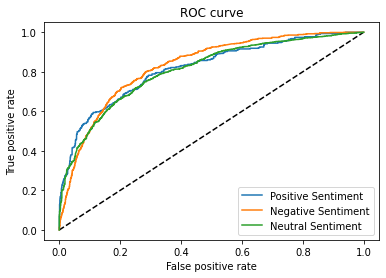

In [165]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [166]:
from sklearn.metrics import f1_score
predicted_labels = pipeline_for_se.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.744944
F1-macro = 0.556631


In [167]:
from sklearn.metrics import classification_report
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.618893  0.495437  0.550326       767
     neutral   0.772589  0.909294  0.835386      2238
    positive   0.815385  0.172078  0.284182       308

    accuracy                       0.744944      3313
   macro avg   0.735622  0.525603  0.556631      3313
weighted avg   0.740985  0.744944  0.718147      3313



~ Searching for params (Grid CV) ~

In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
f1_macro_scorer = make_scorer(f1_score, average='macro')
cv = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3], 'penalty': ['l1', 'l2']},
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [169]:
cv.fit(X_transformed_and_selected, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10.0, 100.0, 1000.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [170]:
print(cv.best_params_)

{'C': 100.0, 'penalty': 'l2'}


~ Testing Logistic Regression (with super params) ~

In [171]:
best_cls = LogisticRegression(solver='liblinear', verbose=True, C=10.0, penalty='l1')
best_cls.fit(X_transformed_and_selected, labels)

[LibLinear]

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=True, warm_start=False)

In [172]:
best_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', best_cls)
    ]
)

In [173]:
probabilities = best_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

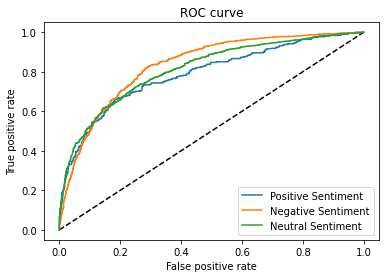

In [174]:
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [175]:
predicted_labels = best_pipeline_for_se.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.721401
F1-macro = 0.589156


In [176]:
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.564935  0.567145  0.566038       767
     neutral   0.807877  0.824844  0.816272      2238
    positive   0.422481  0.353896  0.385159       308

    accuracy                       0.721401      3313
   macro avg   0.598431  0.581961  0.589156      3313
weighted avg   0.715804  0.721401  0.718261      3313



In [180]:
import time

~ Searching for params (Randomized CV) ~

In [177]:
from sklearn.model_selection import RandomizedSearchCV

In [186]:
rand_cv = RandomizedSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_distributions={
                'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3], 
                'penalty': ['l1', 'l2', 'elasticnet']
                },
    n_iter = 100,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [187]:
t_sps1 = time.time()

rand_cv.fit(X_transformed_and_selected, labels)

t_sps2 = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [188]:
print('Time needed for search: ', t_sps2 - t_sps1)
print(rand_cv.best_params_)

Time needed for search:  6.416665077209473
{'penalty': 'l2', 'C': 100.0}


In [189]:
t_sps3 = time.time()

rand_cls = LogisticRegression(solver='liblinear', verbose=True, C=100.0, penalty='l2')
rand_cls.fit(X_transformed_and_selected, labels)

t_sps4 = time.time()
print('Time needed for computations: ', t_sps4 - t_sps3)

[LibLinear]Time needed for computations:  0.1839313507080078


In [202]:
rand_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', rand_cls)
    ]
)

In [191]:
probabilities = rand_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

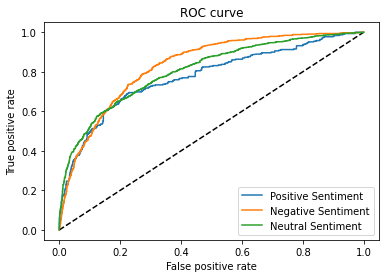

In [192]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [193]:
predicted_labels = rand_pipeline_for_se.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.718080
F1-macro = 0.584246


In [194]:
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.552664  0.581486  0.566709       767
     neutral   0.809376  0.817694  0.813514      2238
    positive   0.420408  0.334416  0.372514       308

    accuracy                       0.718080      3313
   macro avg   0.594150  0.577865  0.584246      3313
weighted avg   0.713783  0.718080  0.715377      3313



~ Testing SGDClassifier ~

In [216]:
from sklearn.linear_model import SGDClassifier

In [217]:
sgdc = SGDClassifier( 
                     loss='log',
                     max_iter=100
                    )

In [218]:
tp1 = time.time()

sgdc.fit(X_transformed_and_selected, labels)

tp2 = time.time()

In [219]:
print('Time needed for computations: ', tp2 - tp1)

Time needed for computations:  0.049811363220214844


In [220]:
sgdc_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', sgdc)
    ]
)

In [221]:
probabilities = sgdc_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
y_score_neutrals = probabilities[:, classes_list.index('neutral')]
fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

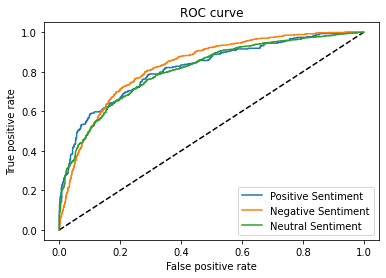

In [222]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [223]:
predicted_labels = sgdc_pipeline_for_se.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.744340
F1-macro = 0.557331


In [224]:
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.617504  0.496741  0.550578       767
     neutral   0.773125  0.907507  0.834943      2238
    positive   0.782609  0.175325  0.286472       308

    accuracy                       0.744340      3313
   macro avg   0.724413  0.526524  0.557331      3313
weighted avg   0.737979  0.744340  0.718120      3313



~ Итоги ~

In [ ]:
'''
              --- RandomSCV + LogRegr ---
               (time for search = 6.41s)
              F1-micro = 0.718080
              F1-macro = 0.584246

              precision    recall  f1-score   support

    negative   0.552664  0.581486  0.566709       767
     neutral   0.809376  0.817694  0.813514      2238
    positive   0.420408  0.334416  0.372514       308

    accuracy                       0.718080      3313
   macro avg   0.594150  0.577865  0.584246      3313
weighted avg   0.713783  0.718080  0.715377      3313


                 --- SGDClassifier ---
              (time for computation = 0.49s)
                F1-micro = 0.744340
                F1-macro = 0.557331
                  
                  precision    recall  f1-score   support
        negative   0.617504  0.496741  0.550578       767
         neutral   0.773125  0.907507  0.834943      2238
        positive   0.782609  0.175325  0.286472       308

        accuracy                       0.744340      3313
       macro avg   0.724413  0.526524  0.557331      3313
    weighted avg   0.737979  0.744340  0.718120      3313
    
    # по качеству схоластический градиентный спуск ближе к той регрессии, 
      параметры для которой мы подобрали не самым оптимальным образом 
'''